In [1]:
import pandas as pd
import numpy as np
import re, os, sys, glob, fileinput
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model

plt.close('all')

Long term goal is to integrate with datawrangler, so I need to be able to call from the archived data files based on what the expected architecture may be.

Right now, the Q5 files are to be exported to the box folder "Experimental_Plans" under the experiment ID. The folder is expected to contain the following:

1. the merged data from datawrangler. This will also include the descriptors of the samples in future iterations.
2. qPCR folder containing:
    1. plate map
    2. exported qPCR data


In [2]:
exptID = "/FD0040"

exptFolder = "/Users/austinso/Box Sync/Experimental_Plans/FD (FFPE DNA)" + exptID
dataFolder = "/Users/austinso/Box Sync/Pilot Runs Raw Data/Kapa_HG" + exptID

Data from the Q5 exported table (analyzed) is merged to the plate map that was used for the experiment to allow unstructured slurping of the data (both as excel files).

Q5 qPCR data is exported as a single file with multiple worksheets in to the "Pilot Runs Raw Data/Kapa_HG" folder within the experimental ID subfolder. The relevant worksheet is the "Results" worksheet (generated by the Q5 software), and taking the "Well Position" and the "CT" column values.

"platemap" is a file within the "Experimental Plans/FD (FFPE DNA)" folder within the experimental ID subfolder that outlines the actual sample allocation across the plate. Additional data files are utilized within this folder to parse information and provide basis for analyses.

Note: I need to address the case where there are multiple runs for a given experiment (i.e. multiple plates). It is probably best either create a specific plate name (used to save the file in the Q5 software).

So start off by reading in all the files within both folders.

In [3]:
files = glob.glob(dataFolder+"/*.xls")
list_of_dfs = [pd.read_excel(f,sheet_name="Results", header=None, usecols="B,I", dtype={'I':np.float64}, na_values='CT').dropna(axis=0, subset=[1]) for f in files]

p = re.compile(r'(\d+).\w+$')
for dataframe, f in zip(list_of_dfs, files):
  dataframe[2] = re.search(p,f).group(1)

qPCRdata = pd.concat(list_of_dfs, ignore_index=True)
qPCRdata = qPCRdata.rename(columns={0:'Well Position',1:'CT',2:'plateID'}).replace('Undetermined', np.nan)

qPCRdata.head()

,Well Position,CT,plateID
0,A1,23.652348,2
1,A2,23.583027,2
2,A3,23.588684,2
3,A4,23.635933,2
4,A5,38.657291,2


In [4]:
files = glob.glob(exptFolder+"/platemap*.csv")
list_of_dfs = [pd.read_csv(f,index_col=0) for f in files]

platemaps = pd.DataFrame()
p = re.compile(r'(\d+).\w+$')
for sampleID, f in zip(list_of_dfs, files):
    sampleID = sampleID.stack().reset_index()
    sampleID['Well Position']=sampleID["level_0"].map(str) + sampleID["level_1"].map(str)
    sampleID.drop(['level_0', 'level_1'], axis=1)
    sampleID.rename(columns={0: 'sampleName'}, inplace=True)

    name = sampleID.sampleName.str.split(pat="-",expand=True)
    sampleID['name']=name[0]
    sampleID['dilution']=name[1].astype('float')
    sampleID['n']=name[2]

    sampleID['plateID'] = re.search(p,f).group(1)
    platemaps=pd.concat([platemaps,sampleID[['plateID','Well Position', 'name', 'dilution']]],ignore_index=True).fillna(1)

platemaps.head()

,plateID,Well Position,name,dilution
0,4,A1,s1,1.0
1,4,A2,s1,1.0
2,4,A3,s1,1.0
3,4,A4,s1,1.0
4,4,A5,FDBA007a,80.0


Now I can join the two tables to create the master data table for subsequent analysis:

In [5]:
dataTable = pd.merge(platemaps,qPCRdata,how='left',on=['plateID','Well Position'])
dataTable.dtypes

plateID           object
Well Position     object
name              object
dilution         float64
CT               float64
dtype: object

In [6]:
dataTable.head()

,plateID,Well Position,name,dilution,CT
0,4,A1,s1,1.0,23.769003
1,4,A2,s1,1.0,23.811769
2,4,A3,s1,1.0,23.789612
3,4,A4,s1,1.0,23.930574
4,4,A5,FDBA007a,80.0,NaN


In [7]:
standardData = dataTable[dataTable.name.str.contains('s')]

In [8]:
standards = pd.DataFrame({'name':['s1','s2','s3','s4','s5'],
                          'conc':[2.5000,0.6250,0.1560,0.0391,0.0098]},dtype='float')
standards['logConc']=np.log10(standards.conc)

In [9]:
standards = pd.merge(standards,standardData)

In [10]:
standards.head()

,name,conc,logConc,plateID,Well Position,dilution,CT
0,s1,2.5,0.39794,4,A1,1.0,23.769003
1,s1,2.5,0.39794,4,A2,1.0,23.811769
2,s1,2.5,0.39794,4,A3,1.0,23.789612
3,s1,2.5,0.39794,4,A4,1.0,23.930574
4,s1,2.5,0.39794,4,B1,1.0,23.972134


No handles with labels found to put in legend.


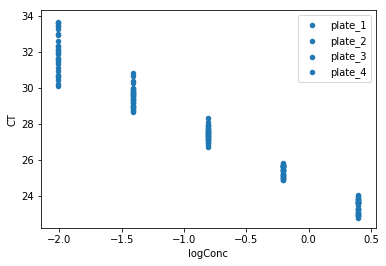

In [11]:
ax = plt.gca()
plt.legend()
for plate, group in standards.groupby('plateID'):
    group.plot(x='logConc', y='CT', kind='scatter', ax=ax, label="plate_"+plate)

In [12]:
summary = standards.groupby(['plateID','name','logConc'])['CT'].describe().reset_index()

No handles with labels found to put in legend.


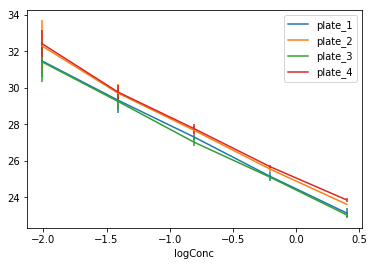

In [13]:
ax = plt.gca()
plt.legend()
for plate, group in summary.groupby('plateID'):
    group.plot(x='logConc', y='mean', yerr='std', ax=ax, label="plate_"+plate)

In [14]:
standardsFit=pd.DataFrame()
fit=pd.DataFrame()

for plate, group in standards.groupby('plateID'):
    #print(plate)
    group = group.dropna()
    #print(group)
    

    X = group['logConc'].values.reshape(-1,1)
    y = group['CT'].values.reshape(-1,1)
    
    lm = linear_model.LinearRegression()
    model = lm.fit(X,y)

    
    fit['intercept'] = lm.intercept_
    fit['slope'] = lm.coef_
    fit['R^2'] = lm.score(X, y)
    fit['plateID'] = plate
    
    
    standardsFit = standardsFit.append(fit,ignore_index=True)
    

In [15]:
standardsFit

,intercept,slope,R^2,plateID
0,24.485186,-3.457663,0.971814,1
1,24.884327,-3.569655,0.954680,2
2,24.367940,-3.458448,0.976677,3
3,25.054321,-3.518858,0.980311,4


Select only data from the samples and convert to concentration using the plate specific standards

In [16]:
sampleData = dataTable[~dataTable.name.str.contains('s')]

In [17]:
sampleData = pd.merge(sampleData,standardsFit,how='left',on=['plateID'])

In [18]:
sampleData['conc']=10**((sampleData['CT']-sampleData['intercept'])/sampleData['slope'])

In [19]:
sampleData['correctedConc']=sampleData['conc']*sampleData['dilution']

In [20]:
sampleData.head()

,plateID,Well Position,name,dilution,CT,intercept,slope,R^2,conc,correctedConc
0,4,A5,FDBA007a,80.0,NaN,25.054321,-3.518858,0.980311,NaN,NaN
1,4,A6,FDBA007a,80.0,33.970074,25.054321,-3.518858,0.980311,0.002926,0.234090
2,4,A7,FDBA008a,80.0,NaN,25.054321,-3.518858,0.980311,NaN,NaN
3,4,A8,FDBA008a,80.0,37.331280,25.054321,-3.518858,0.980311,0.000324,0.025953
4,4,A9,FDBA007a,40.0,34.860218,25.054321,-3.518858,0.980311,0.001634,0.065372


"expSummaryFile" is a file that summarizes the pre and post ITP volumes. This is actually a global repository of data from all runs, from which a merged report is generated through datawrangler.
"lysateLabelFile" is a file that summarizes the samples that are being analyzed for a given experiment.

Note: I need to pull data to summarize analyses, but I also need to push out the finalized data.

In [21]:
#expSummaryFile = pd.read_csv(expFolder+"/merge.csv",usecols="T,CZ,DA", dtype={'CZ,DA':np.float64}, na_values='Undetermined')
expSummaryFile = pd.read_csv(exptFolder+"/merge.csv", na_values=np.nan)
expSummaryFile.head()

,Buffer_Kit_ID,Channel,Chip_ID,Chip_Lot,Chip_Type,Dye,Eluate_ID,Elution_Slope,Experiment_ID,Firmware_0,...,Sample_qBio_ID,Deprecated,Eluate_Qubit_Yield_ng,Eluate_qBiomarker_Yield_ng,Maximum_Chip_Thickness,Minimum_Chip_Thickness,Mixed_Percent_Yield,Qubit_Percent_Yield,Theoretical_Yield_ng,qBiomarker_Percent_Yield
0,FFPE Buffers,A,126.0,P3061804,C3E24S1,True,0_00A,NaN,FD0019,V0.23,...,NaN,True,NaN,NaN,8.095,7.996,NaN,NaN,NaN,NaN
1,FFPE Buffers,B,126.0,P3061804,C3E24S1,True,0_00B,NaN,FD0019,V0.23,...,NaN,True,NaN,NaN,8.095,7.996,NaN,NaN,NaN,NaN
2,FFPE Buffers,C,126.0,P3061804,C3E24S1,True,0_00C,NaN,FD0019,V0.23,...,NaN,True,NaN,NaN,8.095,7.996,NaN,NaN,NaN,NaN
3,FFPE Buffers,D,126.0,P3061804,C3E24S1,True,0_00D,NaN,FD0019,V0.23,...,NaN,True,NaN,NaN,8.095,7.996,NaN,NaN,NaN,NaN
4,FFPE Buffers,E,126.0,P3061804,C3E24S1,True,0_00E,NaN,FD0019,V0.23,...,NaN,True,NaN,NaN,8.095,7.996,NaN,NaN,NaN,NaN


In [22]:
lysateLabelFile = pd.read_csv(exptFolder+"/FD_Lysates_20190305.101703.csv", na_values=np.nan)
lysateLabelFile.head()

,Operator,Date,Experiment,ID,Block_ID,Tissue_Type,Note,Slice_ID,Protocol_Version,Lysate_Volume
0,Austin,3/5/19,FD0040,FDBA001a,BA,Breast,untrimmed,1,NaN,NaN
1,Austin,3/5/19,FD0040,FDBA002a,BA,Breast,untrimmed,4,NaN,NaN
2,Austin,3/5/19,FD0040,FDBA003a,BA,Breast,untrimmed,7,NaN,NaN
3,Austin,3/5/19,FD0040,FDBA004a,BA,Breast,untrimmed,10,NaN,NaN
4,Austin,3/5/19,FD0040,FDBA005a,BA,Breast,untrimmed,13,NaN,NaN


Hmmm...the more I think about this, I think that this sampleData table should be pushed to the expSummaryFile, and then the analysis should be taken from there. However, the issue is in how to account for the granular-level data that allows you to go to a deep-dive in the data i.e. demonstrating inhibition through dilutions, or looking at outliers, etc...



In [23]:
lysateData = pd.merge(sampleData, expSummaryFile[['Lysate_ID','Input_Volume_ul']], how='inner', left_on='name', right_on='Lysate_ID',)
eluateData = pd.merge(sampleData, expSummaryFile[['Lysate_ID','Eluate_ID','Eluate_Volume_ul']], how='inner', left_on='name', right_on='Eluate_ID')
summaryData = pd.merge(lysateData,eluateData,how='outer')
summaryData.head()

,plateID,Well Position,name,dilution,CT,intercept,slope,R^2,conc,correctedConc,Lysate_ID,Input_Volume_ul,Eluate_ID,Eluate_Volume_ul
0,4,A5,FDBA007a,80.0,NaN,25.054321,-3.518858,0.980311,NaN,NaN,FDBA007a,210.0,NaN,NaN
1,4,A6,FDBA007a,80.0,33.970074,25.054321,-3.518858,0.980311,0.002926,0.234090,FDBA007a,210.0,NaN,NaN
2,4,A9,FDBA007a,40.0,34.860218,25.054321,-3.518858,0.980311,0.001634,0.065372,FDBA007a,210.0,NaN,NaN
3,4,A10,FDBA007a,40.0,39.536823,25.054321,-3.518858,0.980311,0.000077,0.003065,FDBA007a,210.0,NaN,NaN
4,4,A13,FDBA007a,20.0,32.556915,25.054321,-3.518858,0.980311,0.007377,0.147543,FDBA007a,210.0,NaN,NaN


In [24]:
summaryData = pd.merge(summaryData,lysateLabelFile[['ID','Block_ID','Note']], how='inner', left_on='Lysate_ID', right_on='ID')
summaryData.head()

,plateID,Well Position,name,dilution,CT,intercept,slope,R^2,conc,correctedConc,Lysate_ID,Input_Volume_ul,Eluate_ID,Eluate_Volume_ul,ID,Block_ID,Note
0,4,A5,FDBA007a,80.0,NaN,25.054321,-3.518858,0.980311,NaN,NaN,FDBA007a,210.0,NaN,NaN,FDBA007a,BA,untrimmed
1,4,A6,FDBA007a,80.0,33.970074,25.054321,-3.518858,0.980311,0.002926,0.234090,FDBA007a,210.0,NaN,NaN,FDBA007a,BA,untrimmed
2,4,A9,FDBA007a,40.0,34.860218,25.054321,-3.518858,0.980311,0.001634,0.065372,FDBA007a,210.0,NaN,NaN,FDBA007a,BA,untrimmed
3,4,A10,FDBA007a,40.0,39.536823,25.054321,-3.518858,0.980311,0.000077,0.003065,FDBA007a,210.0,NaN,NaN,FDBA007a,BA,untrimmed
4,4,A13,FDBA007a,20.0,32.556915,25.054321,-3.518858,0.980311,0.007377,0.147543,FDBA007a,210.0,NaN,NaN,FDBA007a,BA,untrimmed


In [25]:
summaryData['mass'] = np.where(summaryData['Eluate_ID'].isnull(), summaryData.correctedConc*summaryData.Input_Volume_ul, summaryData.correctedConc*summaryData.Eluate_Volume_ul)
summaryData['type']=np.where(summaryData['Eluate_ID'].isnull(),'lysate','eluate')
summaryData['Eluate_ID'] = np.where(summaryData['Eluate_ID'].isnull(),'none',summaryData['Eluate_ID'])
summaryData.head()

,plateID,Well Position,name,dilution,CT,intercept,slope,R^2,conc,correctedConc,Lysate_ID,Input_Volume_ul,Eluate_ID,Eluate_Volume_ul,ID,Block_ID,Note,mass,type
0,4,A5,FDBA007a,80.0,NaN,25.054321,-3.518858,0.980311,NaN,NaN,FDBA007a,210.0,none,NaN,FDBA007a,BA,untrimmed,NaN,lysate
1,4,A6,FDBA007a,80.0,33.970074,25.054321,-3.518858,0.980311,0.002926,0.234090,FDBA007a,210.0,none,NaN,FDBA007a,BA,untrimmed,49.158970,lysate
2,4,A9,FDBA007a,40.0,34.860218,25.054321,-3.518858,0.980311,0.001634,0.065372,FDBA007a,210.0,none,NaN,FDBA007a,BA,untrimmed,13.728047,lysate
3,4,A10,FDBA007a,40.0,39.536823,25.054321,-3.518858,0.980311,0.000077,0.003065,FDBA007a,210.0,none,NaN,FDBA007a,BA,untrimmed,0.643571,lysate
4,4,A13,FDBA007a,20.0,32.556915,25.054321,-3.518858,0.980311,0.007377,0.147543,FDBA007a,210.0,none,NaN,FDBA007a,BA,untrimmed,30.984078,lysate


In [26]:
summaryLysate = summaryData.groupby(['Lysate_ID','Eluate_ID'])['mass'].describe().sort_index().reset_index()
summaryLysate.head()

,Lysate_ID,Eluate_ID,count,mean,std,min,25%,50%,75%,max
0,FDBA001a,E865_01A,4.0,6.560360,1.337811,5.343584,5.815821,6.228267,6.972806,8.441321
1,FDBA001a,none,12.0,20.426551,13.632578,0.705134,11.658805,19.151896,31.884806,43.829507
2,FDBA002a,E865_03H,4.0,9.292661,3.312957,5.851391,6.765118,9.484691,12.012234,12.349872
3,FDBA002a,none,9.0,22.213194,17.150090,8.143456,11.211007,14.949955,25.547127,62.411819
4,FDBA003a,E865_05G,4.0,10.149150,3.918701,6.788325,7.439249,9.171051,11.880953,15.466173


In [27]:
summaryLysate['CV']=summary['std']/summary['mean']
summaryLysate['95CI']=summary['std']*1.96

In [28]:
summaryLysate.head()

,Lysate_ID,Eluate_ID,count,mean,std,min,25%,50%,75%,max,CV,95CI
0,FDBA001a,E865_01A,4.0,6.560360,1.337811,5.343584,5.815821,6.228267,6.972806,8.441321,0.011797,0.535157
1,FDBA001a,none,12.0,20.426551,13.632578,0.705134,11.658805,19.151896,31.884806,43.829507,0.010055,0.495458
2,FDBA002a,E865_03H,4.0,9.292661,3.312957,5.851391,6.765118,9.484691,12.012234,12.349872,0.006699,0.358419
3,FDBA002a,none,9.0,22.213194,17.150090,8.143456,11.211007,14.949955,25.547127,62.411819,0.023384,1.343417
4,FDBA003a,E865_05G,4.0,10.149150,3.918701,6.788325,7.439249,9.171051,11.880953,15.466173,0.028159,1.736463


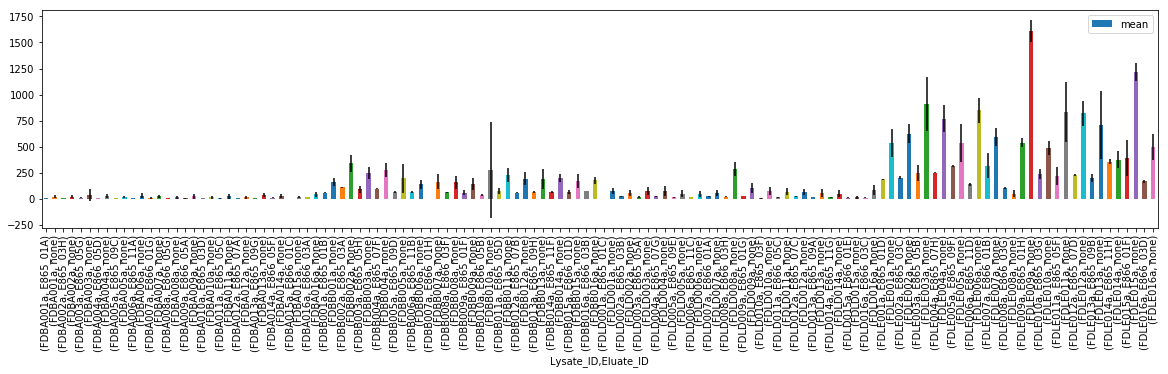

In [29]:
figure = summaryData.groupby(['Lysate_ID','Eluate_ID'])['mass'].describe().sort_index().plot(y='mean', kind='bar',yerr='std',figsize=(20,4))

In [30]:
figure.get_figure().savefig(dataFolder+'/qPCR_yields_lysate.pdf',bbox_inches='tight',dpi=300)

In [31]:
summaryData.to_csv(dataFolder+'/qPCR_parsed.csv')

In [32]:
summaryBlock = summaryData.groupby(['Block_ID','type','Note'])['mass'].describe().sort_index()
summaryBlock

count        mean         std         min  \
Block_ID type   Note                                                   
BA       eluate trimmed     29.0    7.953592    4.132225    0.033932   
                untrimmed   32.0    8.769188    3.218572    3.783504   
         lysate trimmed     82.0   25.143870   21.403721    0.666957   
                untrimmed   82.0   24.455494   26.512113    0.357056   
BB       eluate trimmed     32.0   61.997002   17.599055   29.718462   
                untrimmed   30.0   73.575646   29.259280    0.142962   
         lysate trimmed     95.0  197.204114  171.287063   29.478786   
                untrimmed   96.0  211.149973   99.300961    4.856407   
LD       eluate trimmed     32.0   15.790983    7.864412    1.974565   
                untrimmed   31.0   17.983855    8.289387    0.025534   
         lysate trimmed     89.0   68.709221   42.018964    0.749273   
                untrimmed   91.0   90.806880   85.899556   11.724655   
LE       eluate trimmed     32.0  292.072658  136.197325  146.627645   
                untrimmed   32.0  220.578433   85.687558   96.896382   
         lysate trimmed     96.0  818.493910  425.154769    5.033470   
                untrimmed   96.0  609.874761  287.027425    1.169512   

                                  25%         50%          75%          max  
Block_ID type   Note                                                         
BA       eluate trimmed      5.498102    6.996576    10.448476    16.392938  
                untrimmed    6.747207    8.009703     9.776333    19.589057  
         lysate trimmed     10.222144   19.421208    34.405745   102.033418  
                untrimmed    9.051549   19.151896    34.358197   208.391035  
BB       eluate trimmed     51.637673   60.726391    72.882103   101.870544  
                untrimmed   60.516907   66.688471    98.935364   123.842326  
         lysate trimmed    142.554335  177.657606   218.075420  1722.866284  
                untrimmed  140.142509  187.814495   268.781390   552.336937  
LD       eluate trimmed      9.827725   14.792377    20.989395    31.289491  
                untrimmed   14.000928   17.348319    23.744600    35.678088  
         lysate trimmed     41.058910   60.260319    90.020067   226.273506  
                untrimmed   37.794545   62.574082    97.027614   372.387807  
LE       eluate trimmed    192.457095  257.982459   332.668640   645.797224  
                untrimmed  171.627980  204.451643   261.785686   494.965777  
         lysate trimmed    487.350994  693.709206  1140.660309  1762.986846  
                untrimmed  523.061235  652.445265   772.516476  1678.350127

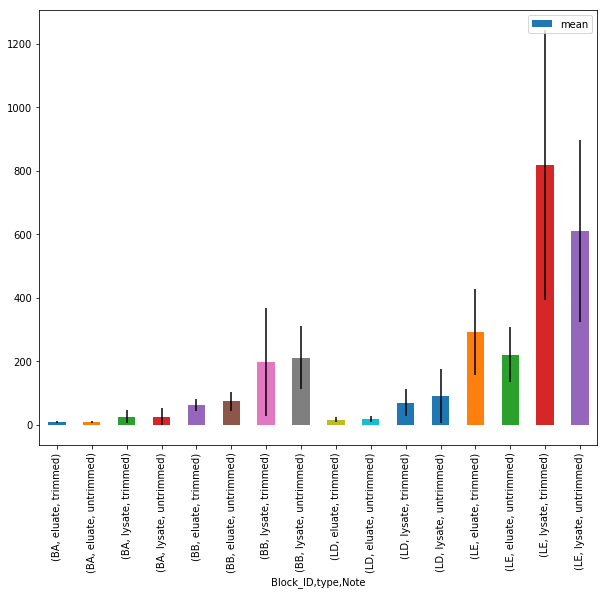

In [33]:
figure = summaryBlock.plot(y='mean', kind='bar',yerr='std',figsize=(10,8))

In [34]:
figure.get_figure().savefig(dataFolder+'/qPCR_yields_block.pdf',bbox_inches='tight',dpi=300)

In [35]:
summaryBlock = summaryBlock.reset_index()

In [37]:
stats.ttest_ind(summaryData.where(summaryData['Note'].str.contains('untrimmed'))['mass'],summaryData.where(summaryData['Note'].str.contains('trimmed'))['mass'],equal_var=True,nan_policy='omit')

Ttest_indResult(statistic=-1.184715759426564, pvalue=0.23632200490322827)